# gwexpy TimeSeries 新機能チュートリアル

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tatsuki-washimi/gwexpy/blob/main/docs/web/en/user_guide/tutorials/intro_timeseries.ipynb)

このノートブックでは、`gwpy` を拡張した `gwexpy` の `TimeSeries` クラスに追加された新しいメソッドとその使い方を解説します。

`gwexpy` は GWpy との高い互換性を維持しつつ、信号処理、統計解析、他ライブラリとの相互運用性を大幅に強化しています。

## 目次
1. 環境セットアップ
2. 信号処理と復調 (Hilbert, Phase, Demodulation)
3. スペクトル解析と相関 (FFT, Transfer Function, xcorr)
4. ヒルベルト・ファン変換 (HHT)
5. 統計・前処理 (Impute, Standardize, ARIMA, Hurst, Rolling)
6. リサンプリングと再インデックス (asfreq, resample)
7. 関数によるフィッティング (fit)
8. 相互運用性 (Pandas, Xarray, Torch, and more)

## 1. 環境セットアップ

まずは必要なライブラリをインポートし、デモ用のサンプルデータを生成します。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u

from gwexpy.noise.wave import chirp, exponential, gaussian, sine
from gwexpy.plot import Plot
from gwexpy.timeseries import TimeSeries

# SampleData Generate (100Hz done5seconds Data)
fs = 100
duration = 5.0
# Restore 't' for compatibility with downstream cells if they use it
t = np.arange(0, duration, 1 / fs)

# Sensor 1: 10Hz Sine wave + Noise
s1 = sine(duration=duration, sample_rate=fs, frequency=10, amplitude=1.0)
n1 = gaussian(duration=duration, sample_rate=fs, std=0.2)
ts1 = s1 + n1
ts1.name = "Sensor 1"
ts1.override_unit("V")

# Sensor 2: Signal (Frequency time / duration : 5Hz -> 25Hz) + Function Width
s2 = chirp(duration=duration, sample_rate=fs, f0=5, f1=25, t1=duration)
env = exponential(
    duration=duration, sample_rate=fs, tau=2.0, decay=False, amplitude=0.2
)
ts2 = s2 * env
ts2.name = "Chirp Signal"
ts2.override_unit("V")

## 2. 信号処理と復調

`gwexpy` では、ヒルベルト変換や包絡線、瞬時周波数の計算、さらにロックインアンプのような復調機能が統合されています。

### ヒルベルト変換と包絡線
`hilbert` と `envelope` を使用します。

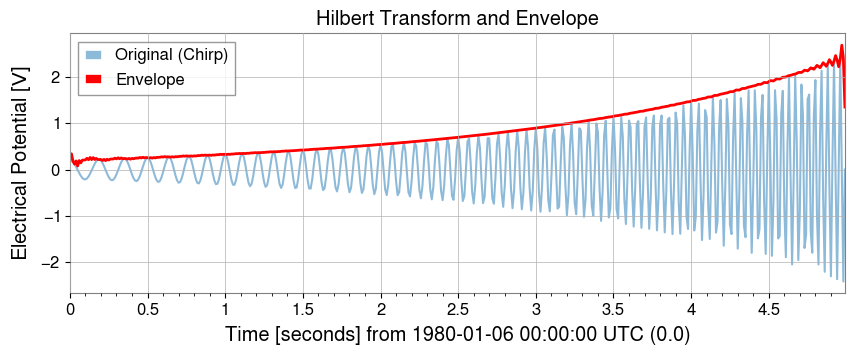

In [2]:
# minutes Signal (Analytic Signal) Calculate
ts_analytic = ts2.hilbert()
# (Envelope) Calculate
ts_env = ts2.envelope()

plot = Plot(ts2, ts_env, figsize=(10, 4))
ax = plot.gca()
ax.get_lines()[0].set_label("Original (Chirp)")
ax.get_lines()[0].set_alpha(0.5)
ax.get_lines()[1].set_label("Envelope")
ax.get_lines()[1].set_color("red")
ax.get_lines()[1].set_linewidth(2)
ax.legend()
ax.set_title("Hilbert Transform and Envelope")
plt.show()

### 瞬時位相と瞬時周波数
`instantaneous_phase` と `instantaneous_frequency` を使用します。位相のアンラップ (`unwrap`) や度の単位 (`deg`) も指定可能です。

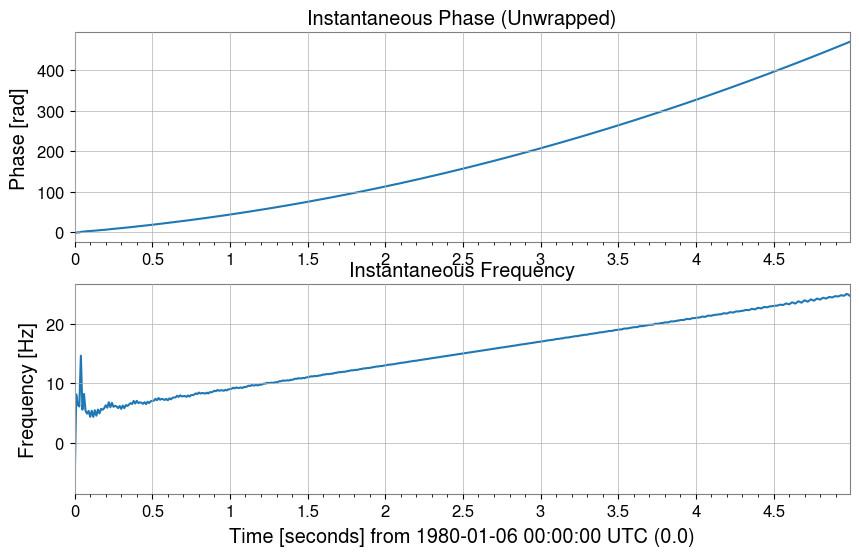

In [3]:
# Phase (unwrap=True Phase )
phase_rad = ts2.instantaneous_phase(unwrap=True)
phase_deg = ts2.instantaneous_phase(deg=True, unwrap=True)

# Frequency
freq = ts2.instantaneous_frequency()

plot = Plot(phase_rad, freq, separate=True, sharex=True, figsize=(10, 6))
ax = plot.axes
ax[0].set_ylabel("Phase [rad]")
ax[0].set_title("Instantaneous Phase (Unwrapped)")
ax[1].set_ylabel("Frequency [Hz]")
ax[1].set_title("Instantaneous Frequency")
plt.show()

### 混合と復調 (Mix-down, Baseband, Lock-in)
特定の周波数成分を抽出したり、直流成分へ落とし込むための機能です。

TimeSeries([0.97370674, 0.88468624, 0.94466389, 0.91826691,
            0.98590416, 0.99147399, 0.81740429, 0.86872436,
            0.96546276, 1.00601311, 0.98659591, 1.07083803,
            1.11321147, 0.98065663, 0.97148967, 0.97054522,
            1.06806132, 0.93631323, 1.09108669, 0.9713755 ,
            1.18166385, 0.91119764, 1.09039806, 1.00949188,
            1.06136118, 1.22433427, 1.02024191, 1.05812867,
            0.96512703, 1.13246248, 0.95906193, 0.95434896,
            1.12796849, 0.97984813, 0.97936352, 1.03768126,
            1.08577858, 1.09392016, 1.07316951, 1.20109265,
            0.94951475, 0.94891906, 0.96796967, 0.93533327,
            0.95583234, 0.95080117, 0.91938513, 1.02361956,
            0.97574212, 1.03086801],
           unit: V,
           t0: 0.0 s,
           dt: 0.1 s,
           name: Sensor 1,
           channel: None)


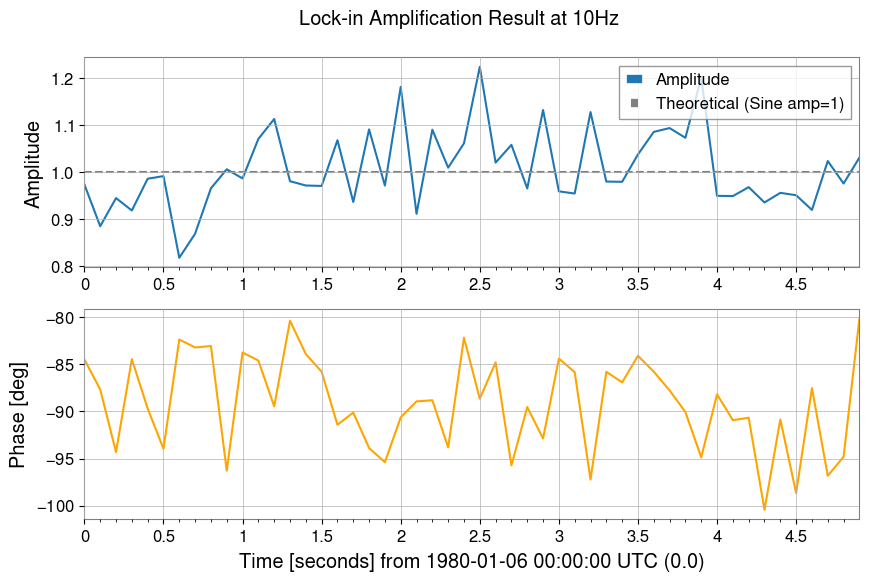

In [4]:
# 1. mix_down: Frequency f0 ( Signal )
ts_mixed = ts1.mix_down(f0=10)

# 2. baseband: demodulation + lowpass + resampling BatchRun
ts_base = ts1.baseband(f0=10, lowpass=5, output_rate=20)

# 3. lock_in: (Amplitude Phase )
amp, ph = ts1.lock_in(f0=10, stride=0.1) # 0.1seconds Mean
res_complex = ts1.lock_in(f0=10, stride=0.1, output="complex") # Complex number

print(amp)

plot = Plot(amp, ph, separate=True, sharex=True, figsize=(10, 6))
ax = plot.axes
ax[0].get_lines()[0].set_label("Amplitude")
ax[0].axhline(1.0, color="gray", linestyle="--", label="Theoretical (Sine amp=1)")
ax[0].set_ylabel("Amplitude")
ax[0].legend()
ax[1].get_lines()[0].set_color("orange")
ax[1].get_lines()[0].set_label("Phase [deg]")
ax[1].set_ylabel("Phase [deg]")
plot.figure.suptitle("Lock-in Amplification Result at 10Hz")
plt.show()

## 3. スペクトル解析と相関

GWpy の機能を継承しつつ、過渡信号向けの `transient` モード FFT や、FFT の直接比による伝達関数計算が追加されています。

### 拡張された FFT
`mode="transient"` を使用すると、ゼロパディングや高速な長さへの調整、左右個別のパディング指定が可能です。

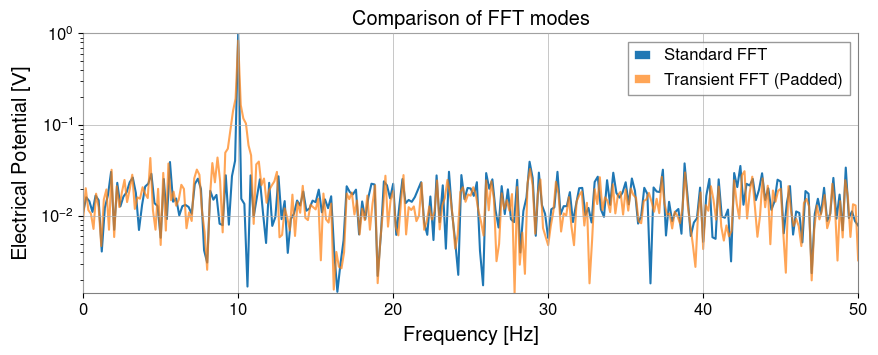

In [5]:
# FFT (GWpy )
fs_gwpy = ts1.fft()

# Transient Mode:
# pad_left/right 。nfft_mode="next_fast_len" Calculate Length 。
fs_trans = ts1.fft(
    mode="transient", pad_left=0.5, pad_right=0.5, nfft_mode="next_fast_len"
)

plot = Plot(fs_gwpy.abs(), fs_trans.abs(), yscale="log", xlim=(0, 50), figsize=(10, 4))
ax = plot.gca()
ax.get_lines()[0].set_label("Standard FFT")
ax.get_lines()[1].set_label("Transient FFT (Padded)")
ax.get_lines()[1].set_alpha(0.7)
ax.legend()
ax.set_title("Comparison of FFT modes")
plt.show()

### 伝達関数 (Transfer Function) と相互相関 (xcorr)
`transfer_function` では Welch法 (`mode="steady"`) だけでなく、FFT の直接比 (`mode="transient"`) も選択できます。

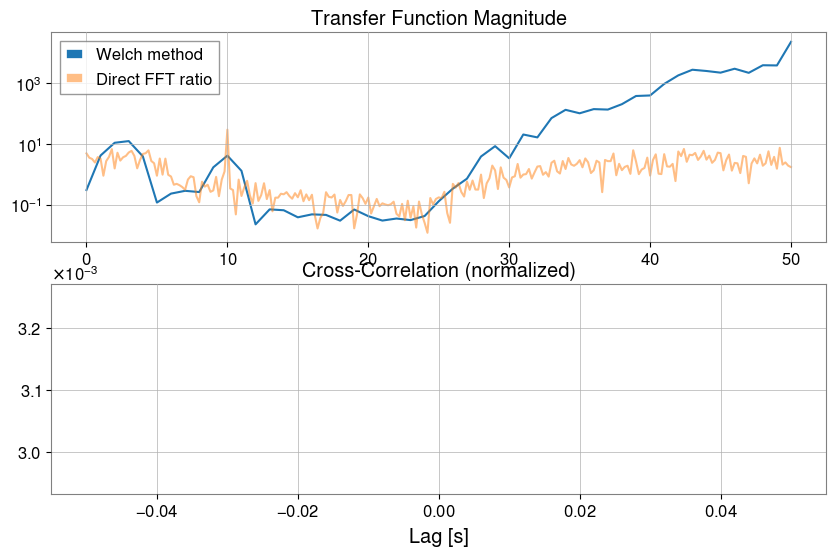

In [6]:
# Transfer Function Calculate (Sensor 1 do Chirp Signal Transfer Function)
tf_welch = ts2.transfer_function(ts1, fftlength=1)
tf_fft = ts2.transfer_function(
    ts1, mode="transient"
) # FFTRatio ( Response )

# CrossCorrelation (xcorr)
corr = ts1.xcorr(ts2, maxlag=0.5, normalize="coeff")

plot = Plot(figsize=(10, 6))
ax1 = plot.add_subplot(2, 1, 1)
ax1.semilogy(tf_welch.frequencies, np.abs(tf_welch), label="Welch method")
ax1.semilogy(tf_fft.frequencies, np.abs(tf_fft), label="Direct FFT ratio", alpha=0.5)
ax1.set_title("Transfer Function Magnitude")
ax1.legend()

ax2 = plot.add_subplot(2, 1, 2)
lag = corr.times.value - corr.t0.value
ax2.plot(lag, corr)
ax2.set_title("Cross-Correlation (normalized)")
ax2.set_xlabel("Lag [s]")
plt.show()

### STLT (Short-Time Laplace Transform)

STLT (Short-Time Laplace Transform) は、信号の時間変化に伴う局所構造を抽出するための変換です。
`gwexpy` では STLT の結果は **(time × sigma × frequency)** の3D変換として `TimePlaneTransform` / `LaplaceGram` で表現されます。

以下は、`stlt` メソッドを使用して STLT を計算し、特定時刻のスライス (`Plane2D`) を抽出する例です。
この例では `frequencies`（Hz）を指定し、任意周波数点で STLT を評価します。

In [7]:
# Data ( )
import numpy as np

from gwexpy.plot import Plot

t = np.linspace(0, 10, 1000)
data = TimeSeries(np.sin(2 * np.pi * 1 * t), times=t * u.s, unit="V", name="Demo Data")

# STLT Run
# stride: time / duration , window:
freqs = np.array([0.5, 1.0, 1.5]) # Hz
stlt_result = data.stlt(stride="0.5s", window="2s", frequencies=freqs)

print(f"Kind: {stlt_result.kind}")
print(f"Shape: {stlt_result.shape} (Time x Sigma x Frequency)")
print(f"Time Axis: {len(stlt_result.times)} steps")
print(f"Sigma Axis: {len(stlt_result.axis1.index)} bins")
print(f"Frequency Axis: {len(stlt_result.axis2.index)} bins")

# (t=5.0s)
plane_at_5s = stlt_result.at_time(5.0 * u.s)
print(f"Plane at 5.0s shape: {plane_at_5s.shape}")

# Plane2D Verify
print(f"Axis 1: {plane_at_5s.axis1.name}")
print(f"Axis 2: {plane_at_5s.axis2.name}")

Kind: stlt
Shape: (17, 1, 3) (Time x Sigma x Frequency)
Time Axis: 17 steps
Sigma Axis: 1 bins
Frequency Axis: 3 bins
Plane at 5.0s shape: (1, 3)
Axis 1: sigma
Axis 2: frequency


## 4. Hilbert-Huang Transform (HHT)
非線形・非定常信号解析のためのヒルベルト・ファン変換 (HHT) 機能です。
Empirical Mode Decomposition (EMD) とヒルベルトスペクトル解析を組み合わせます。

Extracted IMFs: ['IMF1', 'IMF2', 'IMF3', 'residual']


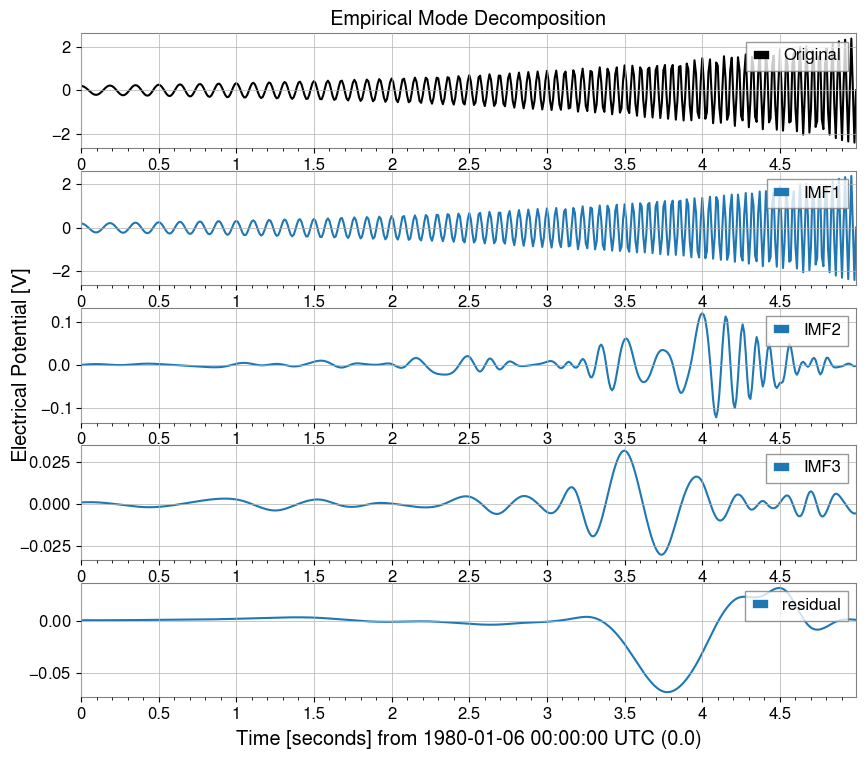

In [8]:
# HHT (Hilbert-Huang Transform)
# Empirical Mode Decomposition (EMD) Run 、IMFs (Intrinsic Mode Functions)
# : Run PyEMD (EMD-signal) : `pip install EMD-signal`

try:
    import os
    import warnings

    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
    warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf")
    warnings.filterwarnings("ignore", message="Protobuf gencode version")
    # EMD Run ( Dictionary)
    # method="emd" ( EMD) "eemd" (Ensemble EMD)
    # ts2 (ChirpSignal )
    imfs = ts2.emd(method="emd", max_imf=3)

    print(f"Extracted IMFs: {list(imfs.keys())}")

    # IMF Plot
    sorted_keys = sorted(
        [k for k in imfs.keys() if k.startswith("IMF")], key=lambda x: int(x[3:])
    )
    if "residual" in imfs:
        sorted_keys.append("residual")

    # gwexpy.plot.Plot BatchPlot
    plot_data = [ts2] + [imfs[k] for k in sorted_keys]
    plot = Plot(*plot_data, separate=True, sharex=True, figsize=(10, 8))

    # Original Set
    ax0 = plot.axes[0]
    ax0.get_lines()[0].set_label("Original")
    ax0.get_lines()[0].set_color("black")
    ax0.legend(loc="upper right")
    ax0.set_title("Empirical Mode Decomposition")

    # IMFs Set
    for i, key in enumerate(sorted_keys):
        ax = plot.axes[i + 1]
        ax.get_lines()[0].set_label(key)
        ax.legend(loc="upper right")

    plt.show()

except ImportError:
    print("EMD-signal not installed. Skipping HHT demo.")
except Exception as e:
    print(f"HHT Error: {e}")

## 5. 統計・前処理

欠損値補完、標準化、ARIMAモデル、ハースト指数、およびローリング統計量が TimeSeries メソッドとして利用可能です。

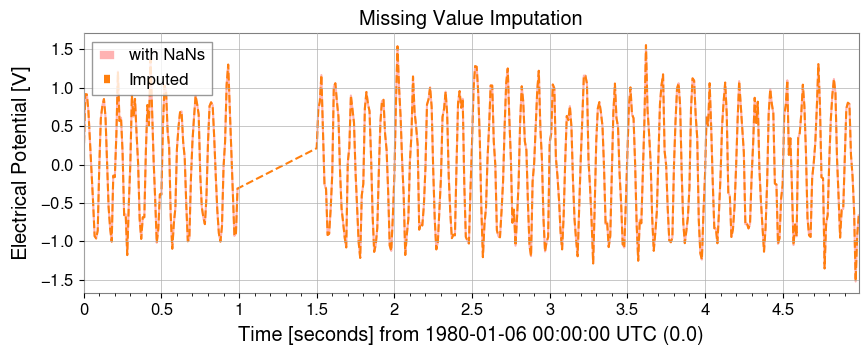

In [9]:
# Data
ts_nan = ts1.copy()
ts_nan.value[100:150] = np.nan

# 1. impute: (interpolation )
ts_imputed = ts_nan.impute(method="interpolate")

# 2. standardize: (z-score, robust )
ts_z = ts1.standardize(method="zscore")
ts_robust = ts1.standardize(method="zscore", robust=True) # Median/IQR

plot = Plot(ts_nan, ts_imputed, figsize=(10, 4))
ax = plot.gca()
ax.get_lines()[0].set_label("with NaNs")
ax.get_lines()[0].set_color("red")
ax.get_lines()[0].set_alpha(0.3)
ax.get_lines()[1].set_label("Imputed")
ax.get_lines()[1].set_linestyle("--")
ax.legend()
ax.set_title("Missing Value Imputation")
plt.show()

### ピーク検出 (Find Peaks)
`scipy.signal.find_peaks` をラップし、時系列データからピークを検出します。

Found 9 peaks
First 5 peaks: TimeSeries([0.25680508, 0.32974425, 0.44255219, 0.58570943,
            0.81881855],
           unit: V,
           t0: 0.5 s,
           dt: 0.5 s,
           name: Chirp Signal_peaks,
           channel: None)


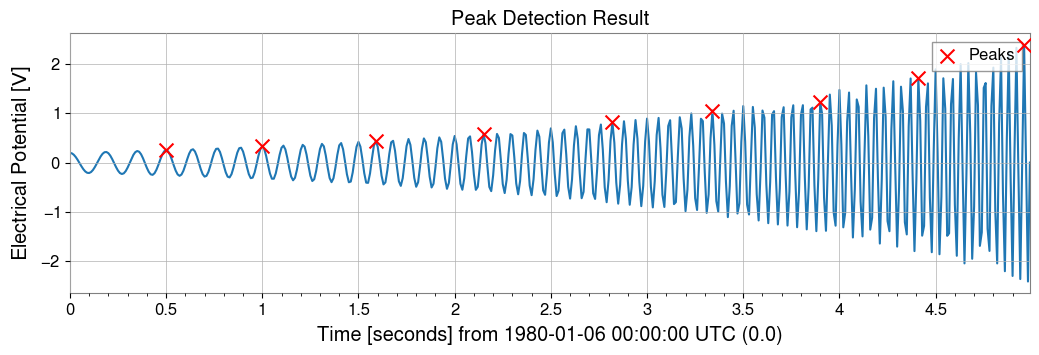

In [10]:
# Peak (Find Peaks)
# height, threshold, distance, prominence, width such as
# Unit Threshold

# ts2 (Chirp + Sine) fromPeak
peaks, props = ts2.find_peaks(height=0.0, distance=50)

print(f"Found {len(peaks)} peaks")
if len(peaks) > 0:
    print("First 5 peaks:", peaks[:5])

# Plot
plot = ts2.plot(figsize=(12, 4))
ax = plot.gca()
ax.scatter(
    peaks.times.value,
    peaks.value,
    marker="x",
    color="red",
    s=100,
    label="Peaks",
    zorder=10,
)
ax.legend(loc="upper right")
ax.set_title("Peak Detection Result")
plt.show()

### ARIMAモデルとハースト指数
※ これらの機能には `statsmodels`, `hurst` 等のライブラリが必要です。

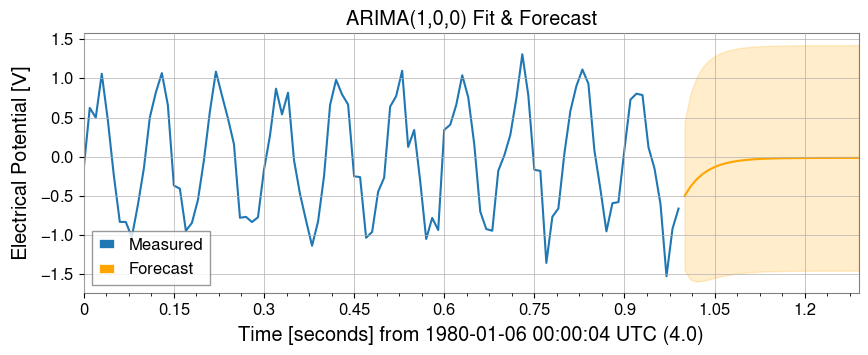

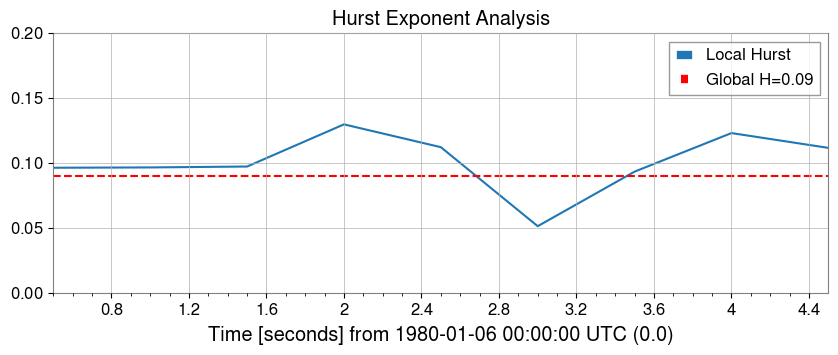

In [11]:
try:
    import os
    import warnings

    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
    warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf")
    warnings.filterwarnings("ignore", message="Protobuf gencode version")
    # 3. fit_arima: ARIMA(1,0,0)
    model = ts1.fit_arima(order=(1, 0, 0))
    resid = model.residuals()
    forecast, conf = model.forecast(steps=30)

    plot = Plot(ts1.tail(100), forecast, figsize=(10, 4))
    ax = plot.gca()
    ax.get_lines()[0].set_label("Measured")
    ax.get_lines()[1].set_label("Forecast")
    ax.get_lines()[1].set_color("orange")

    # Fill between
    ax.fill_between(
        conf["lower"].times.value,
        conf["lower"].value,
        conf["upper"].value,
        alpha=0.2,
        color="orange",
    )

    ax.set_title("ARIMA(1,0,0) Fit & Forecast")
    ax.legend()
    plt.show()
except Exception as e:
    print(f"ARIMA skipping: {e}")

try:
    import os
    import warnings

    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
    warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf")
    warnings.filterwarnings("ignore", message="Protobuf gencode version")
    # 4. hurst / local_hurst: ( Correlation )
    h_val = ts1.hurst()
    h_detail = ts1.hurst(return_details=True) # Detail
    h_local = ts1.local_hurst(window=1.0) # 1seconds

    plot = Plot(h_local, figsize=(10, 4))
    ax = plot.gca()
    ax.get_lines()[0].set_label("Local Hurst")
    ax.axhline(h_val, color="red", linestyle="--", label=f"Global H={h_val:.2f}")
    ax.set_ylim(0, 0.2)
    ax.set_title("Hurst Exponent Analysis")
    ax.legend()
    plt.show()
except Exception as e:
    print(f"Hurst skipping: {e}")

### ローリング統計量 (Rolling Statistics)
Pandas と同様の使い勝手で、`rolling_mean`, `std`, `median`, `min`, `max` が利用できます。

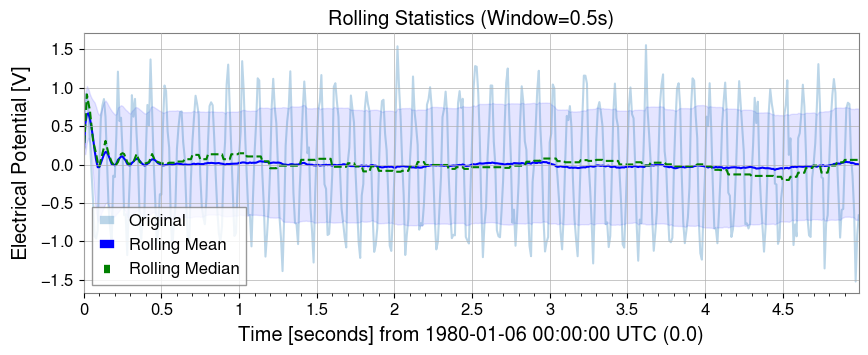

In [12]:
rw = 0.5 * u.s # 0.5seconds
rmean = ts1.rolling_mean(rw)
rstd = ts1.rolling_std(rw)
rmed = ts1.rolling_median(rw)
rmin = ts1.rolling_min(rw)
rmax = ts1.rolling_max(rw)

plot = Plot(ts1, rmean, rmed, figsize=(10, 4))
ax = plot.gca()
ax.get_lines()[0].set_label("Original")
ax.get_lines()[0].set_alpha(0.3)
ax.get_lines()[1].set_label("Rolling Mean")
ax.get_lines()[1].set_color("blue")
ax.get_lines()[2].set_label("Rolling Median")
ax.get_lines()[2].set_color("green")
ax.get_lines()[2].set_linestyle("--")
ax.fill_between(
    rmean.times.value,
    rmean.value - rstd.value,
    rmean.value + rstd.value,
    alpha=0.1,
    color="blue",
)
ax.legend()
ax.set_title("Rolling Statistics (Window=0.5s)")
plt.show()

## 6. リサンプリングと再インデックス

`asfreq` メソッドによる固定グリッドへの割り当てや、`resample` メソッドでの「時間ビン集計」が可能になりました。

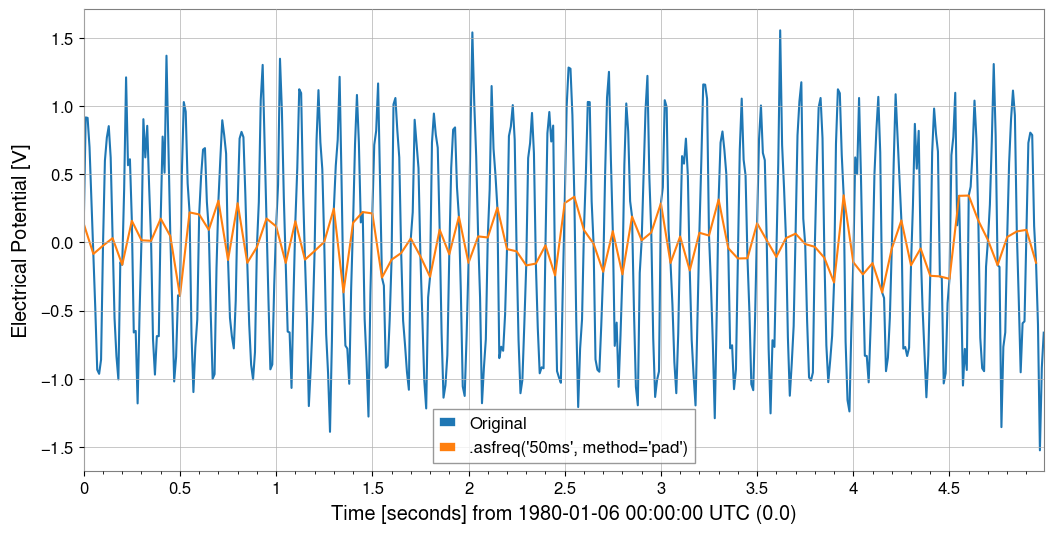

In [13]:
# 1. asfreq: Pandas ('50ms' )
ts_reindexed = ts1.asfreq("50ms", method="pad")
Plot(ts1, ts_reindexed)
plt.legend(["Original", ".asfreq('50ms', method='pad')"])

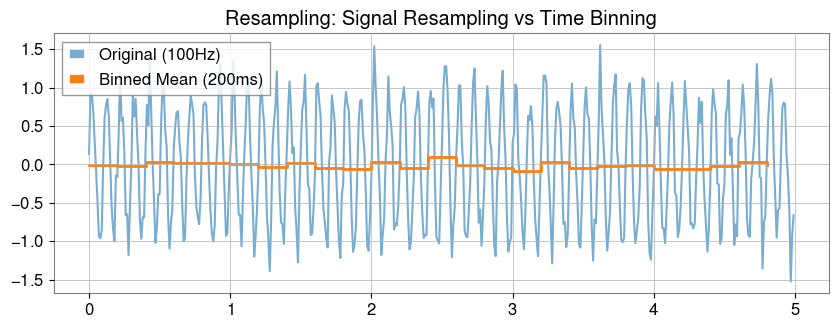

In [14]:
# 2. resample:
# (10Hz) do Signal (GWpy )
ts_sig = ts1.resample(10)
# ('200ms') do 、 time / durationWidth ( )
ts_binned = ts1.resample("200ms") # mean

# Plot doesn't have a direct 'step' method equivalent in args, so we use ax.step or pass to plot
# However, kwarg 'drawstyle'='steps-post' works in plot()? gwpy Plot wraps matplotlib.
# Let's assume we can modify axes after creation or use standard plot for simplicity if appropriate, but step is specific.
# Better strategy: Create Plot instance, then use ax.step
plot = Plot(figsize=(10, 4))
ax = plot.gca()
ax.plot(ts1, alpha=0.6, label="Original (100Hz)")
ax.step(
    ts_binned.times,
    ts_binned.value,
    where="post",
    label="Binned Mean (200ms)",
    linewidth=2,
)
ax.legend()
ax.set_title("Resampling: Signal Resampling vs Time Binning")
plt.show()

## 7. 関数によるフィッティング

`gwexpy` では `iminuit` をベースとした強力なフィッティング機能を提供しています。GWpy の元のクラスを汚染しないよう、`.fit()` メソッドはオプトイン方式になっています。

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.0005703 (χ²/ndof = 0.0)  │              Nfcn = 324              │
│ EDM = 0.000176 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

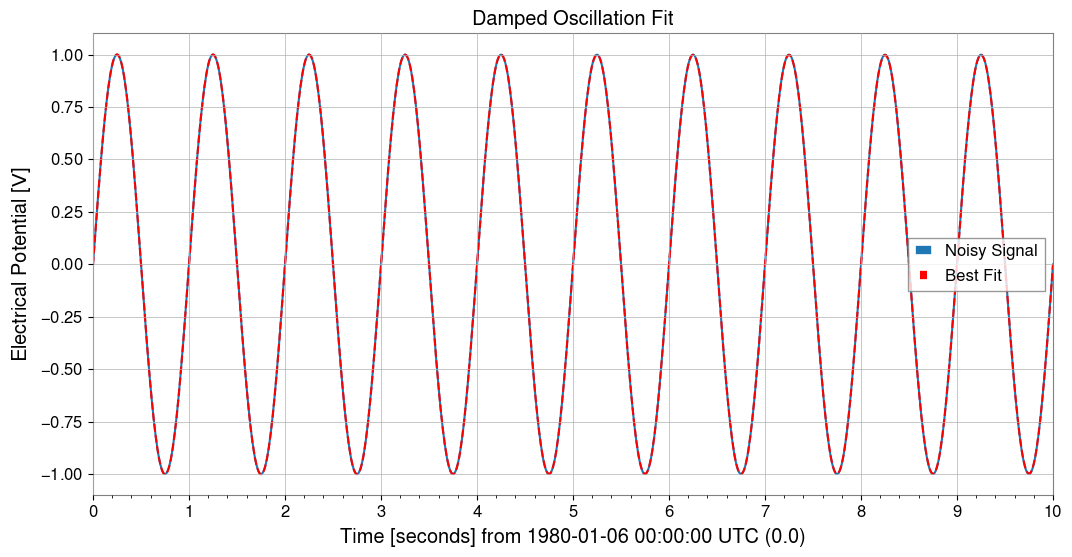

In [15]:
from gwexpy.fitting.models import damped_oscillation

# (Function )
# : A=0.5, tau=0.5, f=15, phi=0
result = data.fit(damped_oscillation, A=0.5, tau=0.5, f=15, phi=0)

# Result Display (iminuit )
print(result)

#
# : x_data Datapoints dotime / duration Array
x_data = data.times.value
best_fit = result.model(x_data)

# Plot
plot = data.plot(label="Noisy Signal")
ax = plot.gca()
ax.plot(data.times, best_fit, label="Best Fit", color="red", linestyle="--")
ax.legend()
ax.set_title("Damped Oscillation Fit")
plt.show()

## 8. 相互運用性

主要なデータサイエンス・機械学習ライブラリとの相互変換が非常にスムーズです。

In [16]:
# Pandas & Xarray
try:
    import os
    import warnings

    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
    warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf")
    warnings.filterwarnings("ignore", message="Protobuf gencode version")
    df = ts1.to_pandas(index="datetime")
    ts_p = TimeSeries.from_pandas(df)
    print("Pandas interop OK")
    display(df)
except ImportError:
    pass

try:
    import os
    import warnings

    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
    warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf")
    warnings.filterwarnings("ignore", message="Protobuf gencode version")
    xr = ts1.to_xarray()
    ts_xr = TimeSeries.from_xarray(xr)
    print("Xarray interop OK")
    print(xr)
except ImportError:
    pass

Pandas interop OK


time_utc
1980-01-06 00:00:19+00:00           0.136702
1980-01-06 00:00:19.010000+00:00    0.916641
1980-01-06 00:00:19.020000+00:00    0.913339
1980-01-06 00:00:19.030000+00:00    0.698927
1980-01-06 00:00:19.040000+00:00    0.307910
                                      ...   
1980-01-06 00:00:23.950000+00:00   -0.148789
1980-01-06 00:00:23.960000+00:00   -0.602931
1980-01-06 00:00:23.970000+00:00   -1.523759
1980-01-06 00:00:23.980000+00:00   -0.917031
1980-01-06 00:00:23.990000+00:00   -0.661017
Name: Sensor 1, Length: 500, dtype: float64

Xarray interop OK
<xarray.DataArray 'Sensor 1' (time: 500)> Size: 4kB
array([ 0.13670173,  0.9166413 ,  0.91333886, ..., -1.5237591 ,
       -0.9170307 , -0.66101744], shape=(500,))
Coordinates:
  * time     (time) datetime64[us] 4kB 1980-01-06T00:00:19 ... 1980-01-06T00:...
Attributes:
    unit:        V
    name:        Sensor 1
    channel:     None
    epoch:       0.0
    time_coord:  datetime


In [17]:
# SQLite ( Save)
import sqlite3

with sqlite3.connect(":memory:") as conn:
    ts1.to_sqlite(conn, series_id="my_sensor")
    ts_sql = TimeSeries.from_sqlite(conn, series_id="my_sensor")
    print(f"SQLite interop OK: {ts_sql.name}")
    display(conn)

SQLite interop OK: my_sensor


In [18]:
# Deep Learning (Torch)
try:
    import os
    import warnings

    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
    warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf")
    warnings.filterwarnings("ignore", message="Protobuf gencode version")
    import torch

    _ = torch
    t_torch = ts1.to_torch()
    ts_f_torch = TimeSeries.from_torch(t_torch, t0=ts1.t0, dt=ts1.dt)
    print(f"Torch interop OK (Shape: {t_torch.shape})")
    display(t_torch)
except ImportError:
    pass

Torch interop OK (Shape: torch.Size([500]))


tensor([ 0.1367,  0.9166,  0.9133,  0.6989,  0.3079, -0.0841, -0.4856, -0.9327,
        -0.9629, -0.8584, -0.0235,  0.5997,  0.7687,  0.8529,  0.6217,  0.0314,
        -0.5548, -0.8344, -1.0038, -0.1451, -0.1633,  0.3889,  1.2103,  0.5661,
         0.6103,  0.1592, -0.6597, -0.6484, -1.1797, -0.5220,  0.0160,  0.9038,
         0.6236,  0.8553,  0.4024,  0.0122, -0.7108, -0.9686, -0.6863, -0.6871,
         0.1749,  0.7761,  0.5115,  1.3691,  0.7149,  0.0465, -0.4601, -1.0190,
        -0.8384, -0.3873, -0.3911,  0.5101,  1.0292,  0.9588,  0.4337,  0.2204,
        -0.6701, -1.0966, -0.7684, -0.5658,  0.2054,  0.4869,  0.6806,  0.6916,
         0.2962,  0.0925, -0.5204, -0.9999, -0.9653, -0.1879,  0.3064,  0.6143,
         0.8960,  0.7870,  0.6509, -0.1282, -0.5529, -0.6885, -0.7764, -0.4266,
         0.2874,  0.7619,  0.8107,  0.7721,  0.3497, -0.1492, -0.6007, -0.8963,
        -1.0040, -0.8043, -0.0340,  0.2960,  1.0429,  1.3018,  0.7348,  0.1753,
        -0.4155, -0.9302, -0.8948, -0.31

In [19]:
# Deep Learning (TensorFlow)
try:
    import os
    import warnings

    os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "3")
    warnings.filterwarnings(
        "ignore", category=UserWarning, module=r"google\.protobuf\..*"
    )
    warnings.filterwarnings(
        "ignore", category=UserWarning, message=r"Protobuf gencode version.*"
    )
    import tensorflow as tf

    _ = tf
    t_tf = ts1.to_tensorflow()
    ts_f_tf = TimeSeries.from_tensorflow(t_tf, t0=ts1.t0, dt=ts1.dt)
    print("TensorFlow interop OK")
    display(t_tf)
except ImportError:
    pass

In [20]:
# ObsPy ( )
try:
    import os
    import warnings

    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
    warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf")
    warnings.filterwarnings("ignore", message="Protobuf gencode version")
    import obspy

    _ = obspy
    tr = ts1.to_obspy()
    ts_f_obspy = TimeSeries.from_obspy(tr)
    print(f"ObsPy interop OK: {tr.id}")
    display(tr)
except ImportError:
    pass

ObsPy interop OK: .Sensor 1..


.Sensor 1.. | 1980-01-06T00:00:00.000000Z - 1980-01-06T00:00:04.990000Z | 100.0 Hz, 500 samples

## まとめ

このチュートリアルでは、`gwexpy.TimeSeries` の主要な拡張機能について学びました：

- **信号処理**: Hilbert変換、復調、拡張FFTモード。
- **統計**: 高度な相関手法 (MIC, Distance Correlation) と ARIMA モデリング。
- **データクリーニング**: 欠損値補完と標準化。
- **相互運用性**: Pandas, Xarray, PyTorch, TensorFlow, ObsPy とのシームレスな変換。

### 次のステップ

- **多チャンネルデータ**: [TimeSeriesMatrix](matrix_timeseries.ipynb) で多数のチャンネルを一括処理する方法を学ぶ。
- **スペクトル解析**: [FrequencySeries](intro_frequencyseries.ipynb) を詳しく見る。
- **4Dフィールド**: [ScalarField](field_scalar_intro.ipynb) で時空間解析を行う。